In [1]:
import os
import tomopy
import numpy as np
import matplotlib.pyplot as plt
import sys
import utilities as rocku
import h5py as h5f
from tqdm import tqdm
import timeit
import multiprocessing as mp

from tifffile import TiffFile
from pprint import pprint
import pandas as pd
# from findpeaks import findpeaks
import plotly.express as px
import plotly.tools as tls
import plotly.offline as py

# %matplotlib notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
ncore = mp.cpu_count()
print("CPU cores:", ncore)

CPU cores: 256


In [2]:
# need to change
ipts="23768"
# scan_type = 'ct_scans'
scan_type = 'radiographs'
# scan_type = 'alignment_calibration'

In [3]:
scan_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/" + scan_type
sorted(os.listdir(scan_loc))

['06_29_21_OB',
 '06_29_21_dark_field',
 '2021_02_25',
 '2021_03_25',
 '2021_04_12',
 '2021_04_14',
 '2021_04_15',
 '2021_04_18_resolution',
 '2021_04_22_25um_scint',
 '2021_04_22_BN_PLA',
 '2021_04_27_light',
 '2021_05_25',
 '2021_07_07_Cu_fastCT',
 '2021_07_07_Cu_fastCT01',
 '2021_07_26',
 '2021_07_26_super_res',
 '2021_09_04_mono_test',
 '2022_01_04_flux',
 '2022_01_04_stability',
 '2022_01_09_stability',
 '2022_01_13_neutron_eater',
 '2022_01_23_recover_from_slits',
 '2022_09_29_startup',
 '2022_11_08_intensity_check',
 '2023_05_23_QHYS',
 '2023_05_23_QHYS_Choppers',
 '2023_05_23_QHYS_gain_tuning',
 '2023_05_24_VENUS_chopper',
 '2023_08_29_beamsize',
 '2023_08_29_cycle503',
 '2024_01_22_QHY_resolution',
 '2024_03_15_QHYL_1X_test_resolution',
 '2024_03_15_idealVac_plate',
 '2024_04_09_cycle_506',
 '2024_04_09_cycle_506_',
 '2024_04_09_cycle_506_8mm',
 '2024_06_10_comm_test',
 '2024_06_11_comm_test',
 '2024_06_20_BM_calibration',
 '2024_06_20_QHY_resolution',
 '2024_06_24_QHYL_resolu

In [7]:
# sample_name = "2024_11_07_optics_scan_pinhole_vert55mm_woDiffuser_30s"
# sample_name = "2024_11_07_optics_scan_pinhole_vert55mm_wDiffuser_30s"
scan_name_list = [
    "2024_07_23_optics_scan_withDiffuser_60mmVertTrans_pinhole_10s",
    # "2024_11_07_optics_scan_pinhole_vert55mm_wDiffuser_30s",
    "2025_09_16_optics_scan_pinhole_vert60mm_with5mmGraphite_10s",
    "2025_09_16_ScanPinhole_vert60mm_with5mmGraphite_10s",
]
################################################################
################################################################
################################################################
################################################################
################################################################
################################################################
path_to_beam_shape = '/SNS/users/y9z/Documents/GitHub/research_stuff/jupyter_notebooks/norm_recon/beam_flux_cg1d.txt'
df = pd.read_csv(path_to_beam_shape, sep='\t', skiprows=0)
df.columns = ['wavelength_A', 'flux']
total_flux = df['flux'].sum()
df['BM_eff'] = rocku.BM_eff*(df['wavelength_A']/rocku.BM_eff_wave)
df['count'] = df['flux']*df['BM_eff']
total_count = df['count'].sum()
df['count_percent'] = df['count']/total_count
meta_df_list = []
for each_scan in scan_name_list:
    scan_dir = os.path.join(scan_loc, each_scan)
    fname_list = os.listdir(scan_dir)
    fname_list.sort()
    lookup_tags = ['BMCounterRate', 'BMCounter', 'MotAperture', 'MotHoriTrans', 'MotVertTrans', 'ExposureTime']
    meta_dict = {}
    for e_tif in fname_list:
        meta_dict[e_tif] = {}
        with TiffFile(os.path.join(scan_dir, e_tif)) as tif:
            for page in tif.pages:
                for tag in page.tags:
                    tag_name, tag_value = tag.name, tag.value
                    if type(tag_value) == str and ':' in tag_value:
                        tag_name = tag_value.split(':')[0]
                        tag_value = tag_value.split(':')[1]
                    if tag_name in lookup_tags:
                        meta_dict[e_tif][tag_name] = float(tag_value)
    #                 print("NAME:", tag_name)
    #                 print("VALUE:", tag_value)
    meta_df = pd.DataFrame.from_dict(meta_dict, orient='index')
    meta_df['Rate'] = meta_df['BMCounter']/meta_df['ExposureTime']
    meta_df['Neutrons_woWaveCorr'] = meta_df['Rate']/(rocku.BM_eff*(2.5/rocku.BM_eff_wave))
    measured_count = meta_df['Rate'].max()
    df['neutrons'] = df['count_percent']*measured_count/df['BM_eff'] # Filling the column
    neutrons_list = []
    for i, each in enumerate(meta_df['Rate']):
        df['neutrons'] = df['count_percent']*each/df['BM_eff']
        _sum = df['neutrons'].sum()
        neutrons_list.append(_sum)
    meta_df['Neutrons'] = neutrons_list
    meta_df_list.append(meta_df)

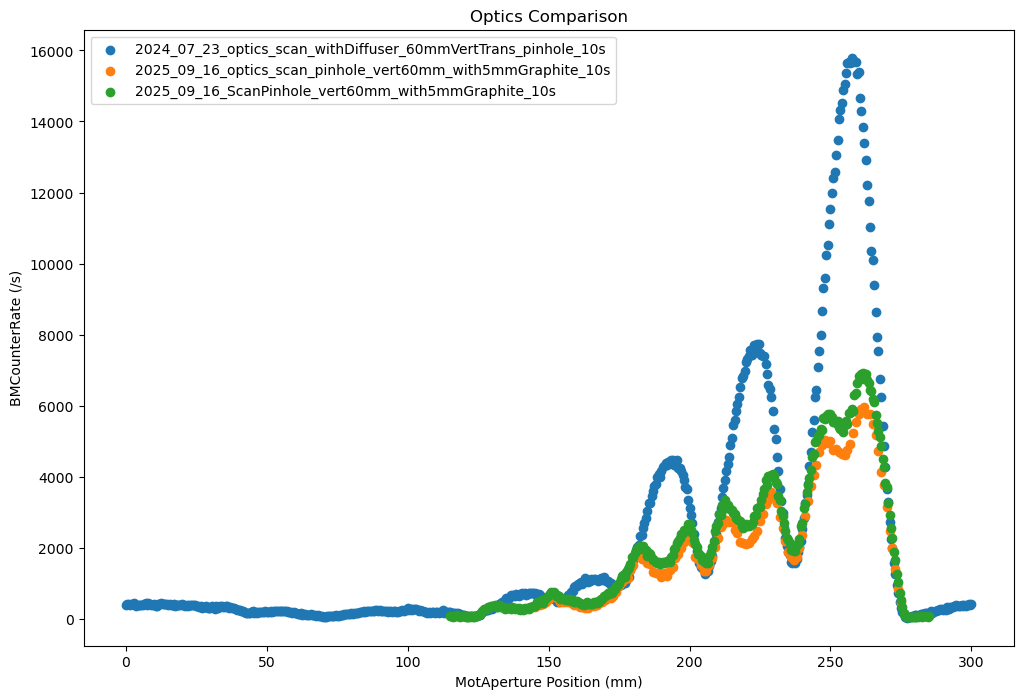

In [9]:
# peaks = find_peaks(meta_df['Rate'], prominence=10000)
pinhole_dia_cm = 1.6
area_cm2 = np.pi*(pinhole_dia_cm/2)**2
# area_cm2 = 0.2*0.2
# print(area_cm2)
x_label = 'MotAperture'
# x_label = 'ExposureTime'
y_label = 'BMCounterRate'
# y_label = 'Rate'
# y_label = 'Neutrons'
####################################
fig_mpl, ax = plt.subplots()            # Create a figure containing a single Axes.
for i, each in enumerate(meta_df_list):
    ax.scatter(meta_df_list[i][x_label], meta_df_list[i][y_label])  # Plot some data on the Axes.
ax.set_title("Optics Comparison")
ax.set_xlabel("{} Position (mm)".format(x_label))
ax.set_ylabel("{} (/s)".format(y_label))
# ax.set_yscale('log')
# ax.set_xscale('log') 
ax.legend(scan_name_list)
# plt.title(sample_name)
# print('Neutrons_woWaveCorr', "max:", meta_df['Neutrons_woWaveCorr'].max())
# print('Neutrons_woWaveCorr', "flux max (n/s/cm2):", meta_df['Neutrons_woWaveCorr'].max()/area_cm2)
# print(y_label, "max:", meta_df[y_label].max())
# print(y_label, "flux max (n/s/cm2):", meta_df['Neutrons'].max()/area_cm2)

/SNS/users/y9z/mamba/envs/rockit/lib/python3.11/site-packages/plotly/matplotlylib/renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/SNS/users/y9z/mamba/envs/rockit/lib/python3.11/site-packages/plotly/matplotlylib/renderer.py:609: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



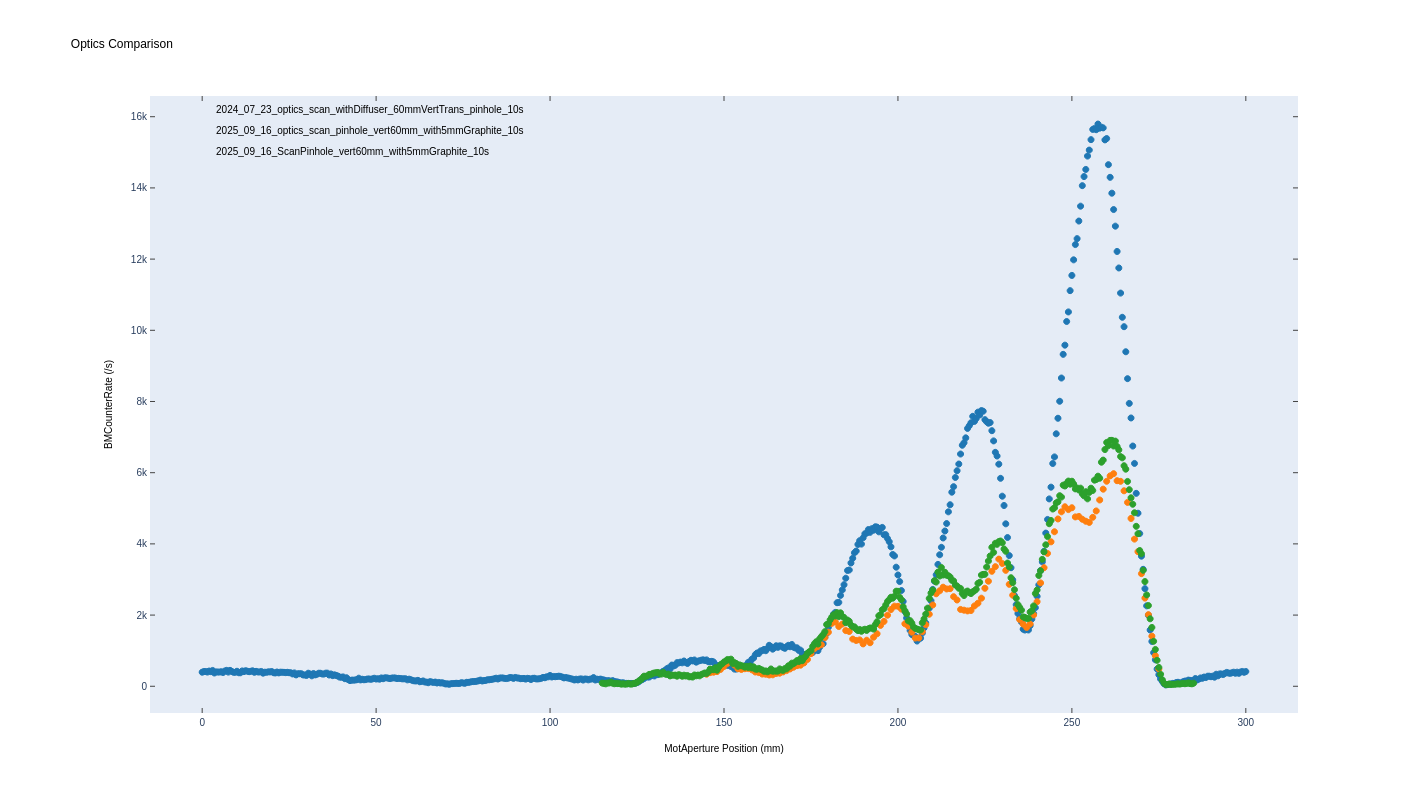

In [10]:
# Convert the Matplotlib figure to a Plotly figure
fig_plotly = tls.mpl_to_plotly(fig_mpl)
# fig_plotly.update_traces(showlegend=True)
py.iplot(fig_plotly)
# Display the Plotly figure (e.g., in an offline HTML file)
# py.plot(fig_plotly, filename="plotly_version_of_mpl_figure.html", auto_open=True)

In [11]:
meta_df.to_clipboard()